In [94]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt


In [95]:
df = pd.read_csv("anomaly_detection.csv", header=0, parse_dates=True, squeeze=True)
# explore data
df.info()
# Insert Date column
df.insert(loc=0, column='DATE', value=pd.date_range(start='01/01/2016', periods=len(df), freq='D'))
df.set_index('DATE', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CEACC   365 non-null    float64
 1   CCDEF   365 non-null    float64
 2   FAXAE   365 non-null    float64
 3   FBFFD   365 non-null    float64
 4   EDDAB   365 non-null    float64
dtypes: float64(5)
memory usage: 14.4 KB


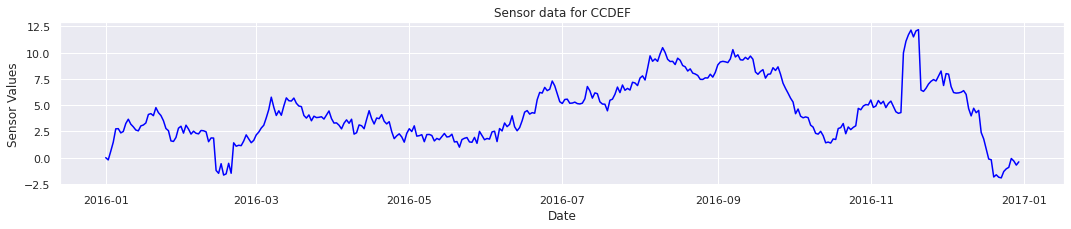

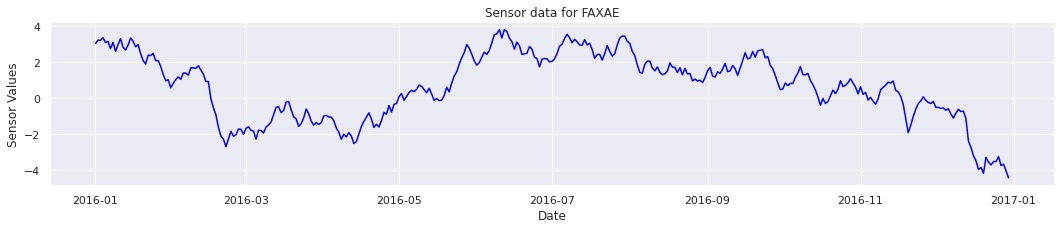

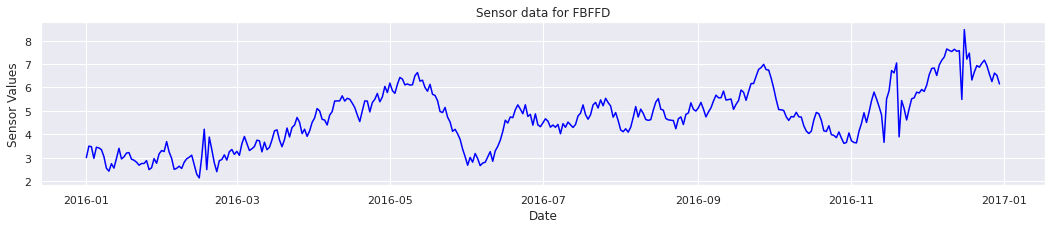

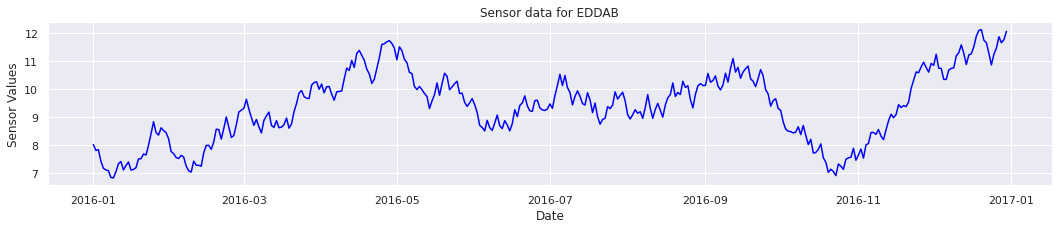

In [96]:
# Extract the names of the numerical columns
names=df.columns
# Plot time series for each sensor
for i, name in enumerate(names):
    if i > 0:
        _ = plt.figure(figsize=(18,3))
        _ = plt.plot(df[name], color='blue')
        _ = plt.title(f'Sensor data for {name}')
        _ = plt.xlabel("Date")
        _ = plt.ylabel("Sensor Values")
        _ = plt.show()
# Looking at the plots, we see that that first and third sensor show
# anomalous behaviour end of February as the analyst identified

In [97]:
train = df['2016-01-01 00:00:00': '2016-09-30 00:00:00']
test = df['2016-10-01 00:00:00':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (274, 5)
Test dataset shape: (91, 5)


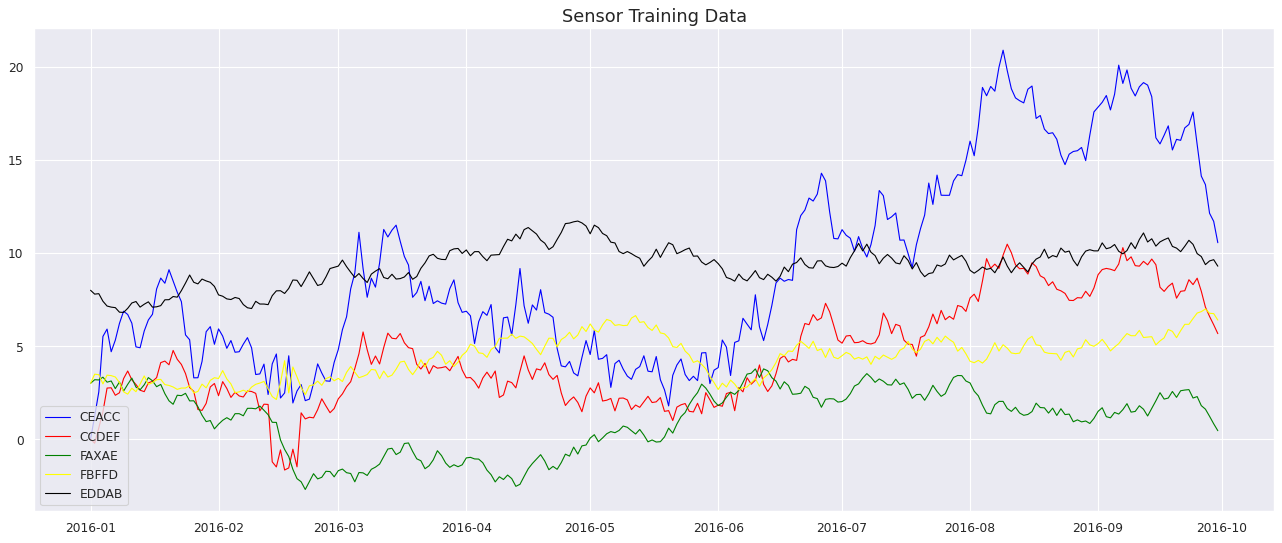

In [98]:
# Plot training set sensor readings.
fig, ax = plt.subplots(figsize=(20, 8), dpi=80)
ax.plot(train['CEACC'], label='CEACC', color='blue', animated = True, linewidth=1)
ax.plot(train['CCDEF'], label='CCDEF', color='red', animated = True, linewidth=1)
ax.plot(train['FAXAE'], label='FAXAE', color='green', animated = True, linewidth=1)
ax.plot(train['FBFFD'], label='FBFFD', color='yellow', animated = True, linewidth=1)
ax.plot(train['EDDAB'], label='EDDAB', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

## Looking at the charts, we spot that CCDEF shows anomalous behaviour as it suddenly drops
# mid February as suggested by the analyst.

In [100]:
# I will use an autoencoder neural network architecture for my anomaly detection model.
# The autoencoder architecture essentially learns an “identity” function.
# It will take the input data, create a compressed representation of the
# core / primary driving features of that data and then learn to reconstruct it again.
# For instance, input an image of a dog, it will compress that data down to the core
# constituents that make up the dog picture and then learn to recreate the original
# picture from the compressed version of the data.



#The rationale for using this architecture for anomaly detection is that I will train
# the model on the training data and determine the resulting reconstruction error.
# Then, when the model encounters data that is outside the norm and attempts to
# reconstruct it, we will see an increase in the reconstruction error as the model
# was never trained to accurately recreate items from outside the norm since anomalies
# are rare and most of the training data exhibits "normal" behaviour.

In [101]:
# Reshape inputs for LSTM since LSTM cells expect a 3 dimensional tensor of the
# form [data samples, time steps, features]
# X_train = (train.shape[0], 1, train.shape[1])
X_train = train.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = test.values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (274, 1, 5)
Test data shape: (91, 1, 5)


In [102]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping

In [103]:
# define the autoencoder network model
def autoencoder_model(X):
    """The first couple of neural network layers create the compressed representation
     of the input data, the encoder. then use a repeat vector layer to distribute
      the compressed representational vector across the time steps of the decoder.
      The final output layer of the decoder provides with the reconstructed input data."""
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)

    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [104]:
# Create the autoencoder model.
# Instantiate the model and compile it using Adam as our neural network optimizer
# and mean absolute error for calculating our loss function.

model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1, 5)]            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 1, 16)             1408      
_________________________________________________________________
lstm_35 (LSTM)               (None, 4)                 336       
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 1, 4)              144       
_________________________________________________________________
lstm_37 (LSTM)               (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 5)              85  

In [105]:
# implement early stopping
early_stopping_monitor = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=40)
# fit the model to the data

history = model.fit(X_train, X_train, epochs=200, batch_size=10,
                    validation_split=0.05, callbacks=early_stopping_monitor).history

Epoch 1/200
26/26 [==============================] - 2s 17ms/step - loss: 5.5939 - val_loss: 8.168
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 5.5794 - val_loss: 8.13
Epoch 3/200
26/26 [==============================] - 0s 3ms/step - loss: 5.6415 - val_loss: 8.07
Epoch 4/200
26/26 [==============================] - 0s 3ms/step - loss: 5.4591 - val_loss: 7.80
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 5.2266 - val_loss: 5.53
Epoch 6/200
26/26 [==============================] - 0s 3ms/step - loss: 3.3861 - val_loss: 2.64
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 2.1098 - val_loss: 1.56
Epoch 8/200
26/26 [==============================] - 0s 3ms/step - loss: 1.6223 - val_loss: 1.40
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 1.5923 - val_loss: 1.27
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 1.4725 - val_loss: 1.21
Epoch 11/200
26/26 [=======

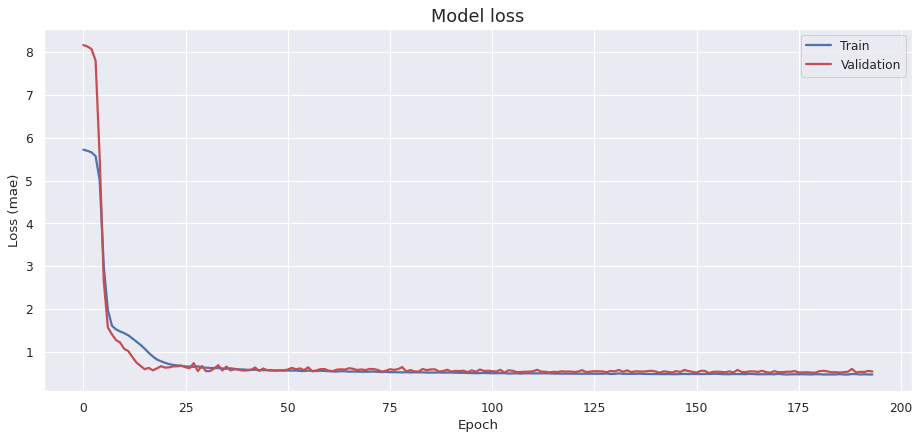

In [106]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/home/nthds/Documents/SparkCognition_Challenge/DS_Challenge_vBS/venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1.75)

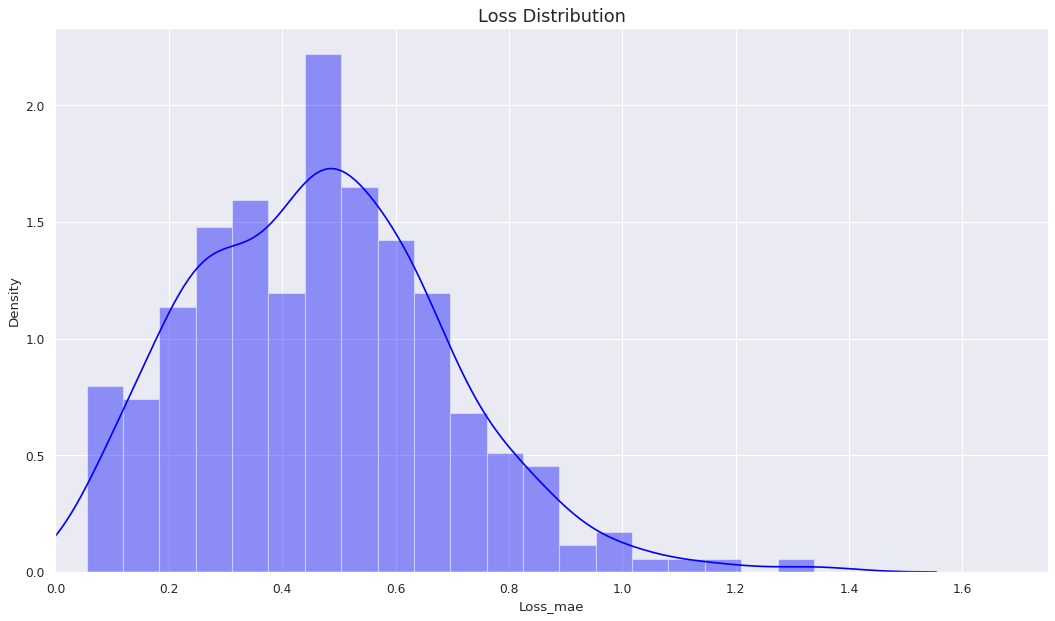

In [114]:
# By plotting the distribution of the calculated loss in the training set, we can use this to identify a
# suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold
# is set above the “noise level” and that any flagged anomalies should be statistically significant above
# the background noise.

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,1.75])


# From the above loss distribution, I will set a maximum threshold value of 1 for
# flagging an anomaly since most values greater than 1 are mostly outliers.
# Then calculate the loss in the test set to check
# when the output crosses the anomaly threshold.


In [180]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 1
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head(100)

,Loss_mae,Threshold,Anomaly
DATE,,,
2016-10-01,0.700471,1,False
2016-10-02,0.381588,1,False
2016-10-03,0.468237,1,False
2016-10-04,0.358645,1,False
2016-10-05,0.362774,1,False
...,...,...,...
2016-12-26,2.350372,1,True
2016-12-27,2.139539,1,True
2016-12-28,2.222652,1,True


In [181]:
# calculate the same metrics for the training set
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])


[Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-17 00:00:00'),
 Timestamp('2016-02-18 00:00:00'),
 Timestamp('2016-02-20 00:00:00'),
 Timestamp('2016-11-14 00:00:00'),
 Timestamp('2016-11-15 00:00:00'),
 Timestamp('2016-11-16 00:00:00'),
 Timestamp('2016-11-17 00:00:00'),
 Timestamp('2016-11-18 00:00:00'),
 Timestamp('2016-11-19 00:00:00'),
 Timestamp('2016-11-20 00:00:00'),
 Timestamp('2016-12-14 00:00:00'),
 Timestamp('2016-12-16 00:00:00'),
 Timestamp('2016-12-17 00:00:00'),
 Timestamp('2016-12-18 00:00:00'),
 Timestamp('2016-12-19 00:00:00'),
 Timestamp('2016-12-20 00:00:00'),
 Timestamp('2016-12-21 00:00:00'),
 Timestamp('2016-12-22 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2016-12-24 00:00:00'),
 Timestamp('2016-12-25 00:00:00'),
 Timestamp('2016-12-26 00:00:00'),
 Timestamp('2016-12-27 00:00:00'),
 Timestamp('2016-12-28 00:00:00'),
 Timestamp('2016-12-29 00:00:00'),
 Timestamp('2016-12-30 00:00:00')]

<AxesSubplot:xlabel='DATE'>

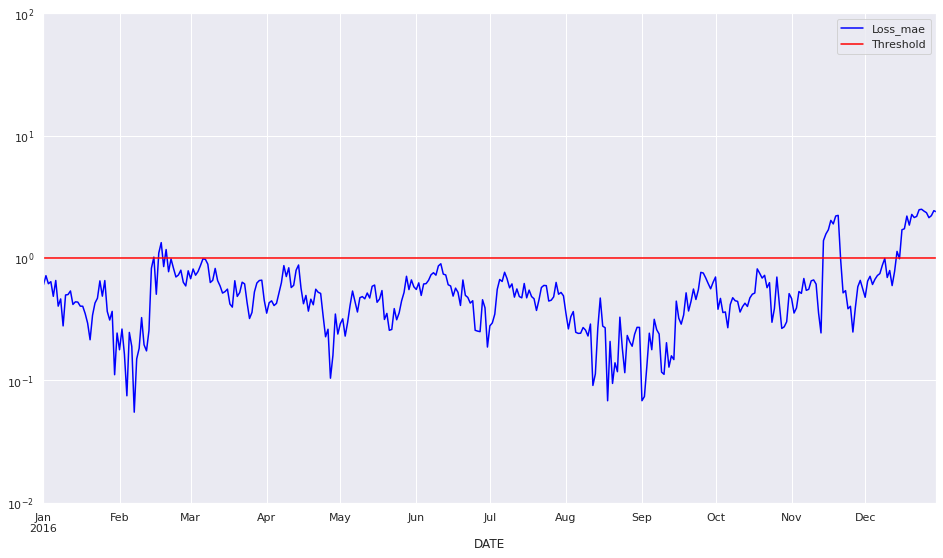

In [182]:
# Plot time plot to get a sense visually where the mean absolute error is greater than
# our set threshold (1).
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

# We see that it is greater in the months of February, November and December.
# This means that our trained model saw an increase in reconstruction error
# in these months as the model could not recreate the items properly that are outside
# the norm. Since they are outside the norm, we can safely say that it is an anomaly

In [183]:
# Find dates where Anomaly is True
scored.index[scored['Anomaly']].tolist()

# We see that a threshold of 1 works quite well since it conforms
# the issues that the analyst saw on the platform in mid February.

[Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-17 00:00:00'),
 Timestamp('2016-02-18 00:00:00'),
 Timestamp('2016-02-20 00:00:00'),
 Timestamp('2016-11-14 00:00:00'),
 Timestamp('2016-11-15 00:00:00'),
 Timestamp('2016-11-16 00:00:00'),
 Timestamp('2016-11-17 00:00:00'),
 Timestamp('2016-11-18 00:00:00'),
 Timestamp('2016-11-19 00:00:00'),
 Timestamp('2016-11-20 00:00:00'),
 Timestamp('2016-12-14 00:00:00'),
 Timestamp('2016-12-16 00:00:00'),
 Timestamp('2016-12-17 00:00:00'),
 Timestamp('2016-12-18 00:00:00'),
 Timestamp('2016-12-19 00:00:00'),
 Timestamp('2016-12-20 00:00:00'),
 Timestamp('2016-12-21 00:00:00'),
 Timestamp('2016-12-22 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2016-12-24 00:00:00'),
 Timestamp('2016-12-25 00:00:00'),
 Timestamp('2016-12-26 00:00:00'),
 Timestamp('2016-12-27 00:00:00'),
 Timestamp('2016-12-28 00:00:00'),
 Timestamp('2016-12-29 00:00:00'),
 Timestamp('2016-12-30 00:00:00')]

In [ ]:
# Therefore, only one anomaly was detected between 10/01/2016 and 12/30/2016.
# Anomalous behavior started from 11/14/2016 and ended on 11/20/2016.
# The behavior in December will not be reported since it is the new normal behavior
# as anomaly lasts more than 14 days.